#Step 1: Environment preparation

##Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

import plotly.graph_objects as go

from sklearn.decomposition import PCA


%matplotlib inline


##Import CSV

In [ ]:
df = pd.read_csv("flying_pokemons_.csv")

##Explore the Dataset

In [ ]:
print(df.head())
print(df.tail())
print("---------------------------------------------------------------------------------------------")
print(df.info())
print("---------------------------------------------------------------------------------------------")
print(df.describe())

  species  bill_length_mm  bill_depth_mm  wind_length_mm  body_mass_g
0   pigey            39.1           18.7           181.0       3000.0
1   pigey            39.5           17.4           186.0       3040.0
2   pigey            40.3           18.0           195.0       2600.0
3   pigey             NaN            NaN             NaN          NaN
4   pigey            36.7           19.3           193.0       2760.0
     species  bill_length_mm  bill_depth_mm  wind_length_mm  body_mass_g
339  pidgeot             NaN            NaN             NaN          NaN
340  pidgeot            46.8           14.3          696.60       4850.0
341  pidgeot            50.4           15.7          719.28       5750.0
342  pidgeot            45.2           14.8          686.88       5200.0
343  pidgeot            49.9           16.1          690.12       5400.0
---------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex

In [ ]:
df.isnull().sum()


species           0
bill_length_mm    2
bill_depth_mm     2
wind_length_mm    2
body_mass_g       2
dtype: int64

##Data cleaning

In [ ]:
df = df.dropna()

##Chart for each possible pair of attributes

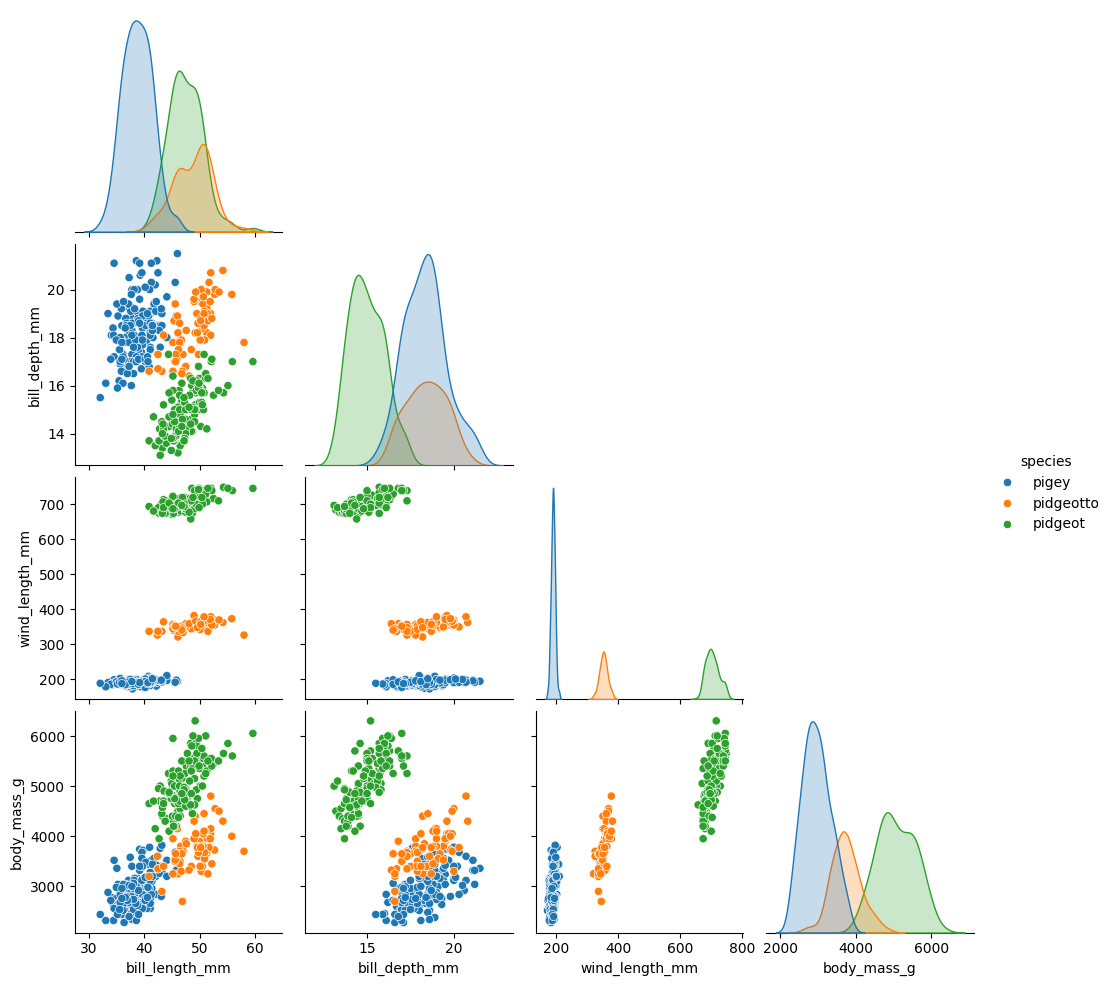

In [ ]:
"""
https://seaborn.pydata.org/generated/seaborn.pairplot.html

This resource was used for this visual representation
"""

sns.pairplot(df, hue='species', corner=True)


##Normalize and Prepare the Dataset

In [ ]:
scaler = MinMaxScaler()
feature_cols = ["bill_length_mm", "bill_depth_mm", "wind_length_mm", "body_mass_g"]
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [ ]:
# Pigey vs Pidgeotto
df_comb1 = df[df["species"].isin(["pigey", "pidgeotto"])].copy()
df_comb1["species"] = df_comb1["species"].map({"pigey": 0, "pidgeotto": 1})

# Pigey vs Pidegot
df_comb2 = df[df["species"].isin(["pigey", "pidgeot"])].copy()
df_comb2["species"] = df_comb2["species"].map({"pigey": 0, "pidgeot": 1})

# Pidgeotto vs Pidgeot
df_comb3 = df[df["species"].isin(["pidgeotto", "pidgeot"])].copy()
df_comb3["species"] = df_comb3["species"].map({"pidgeotto": 0, "pidgeot": 1})



#Step 2: Implementation

###Selection of two types of pokemons

In [ ]:
# We create the df_pairplot only with Pigey y Pidgeotto
df_pairplot = df[df["species"].isin(["pigey", "pidgeotto"])].copy()


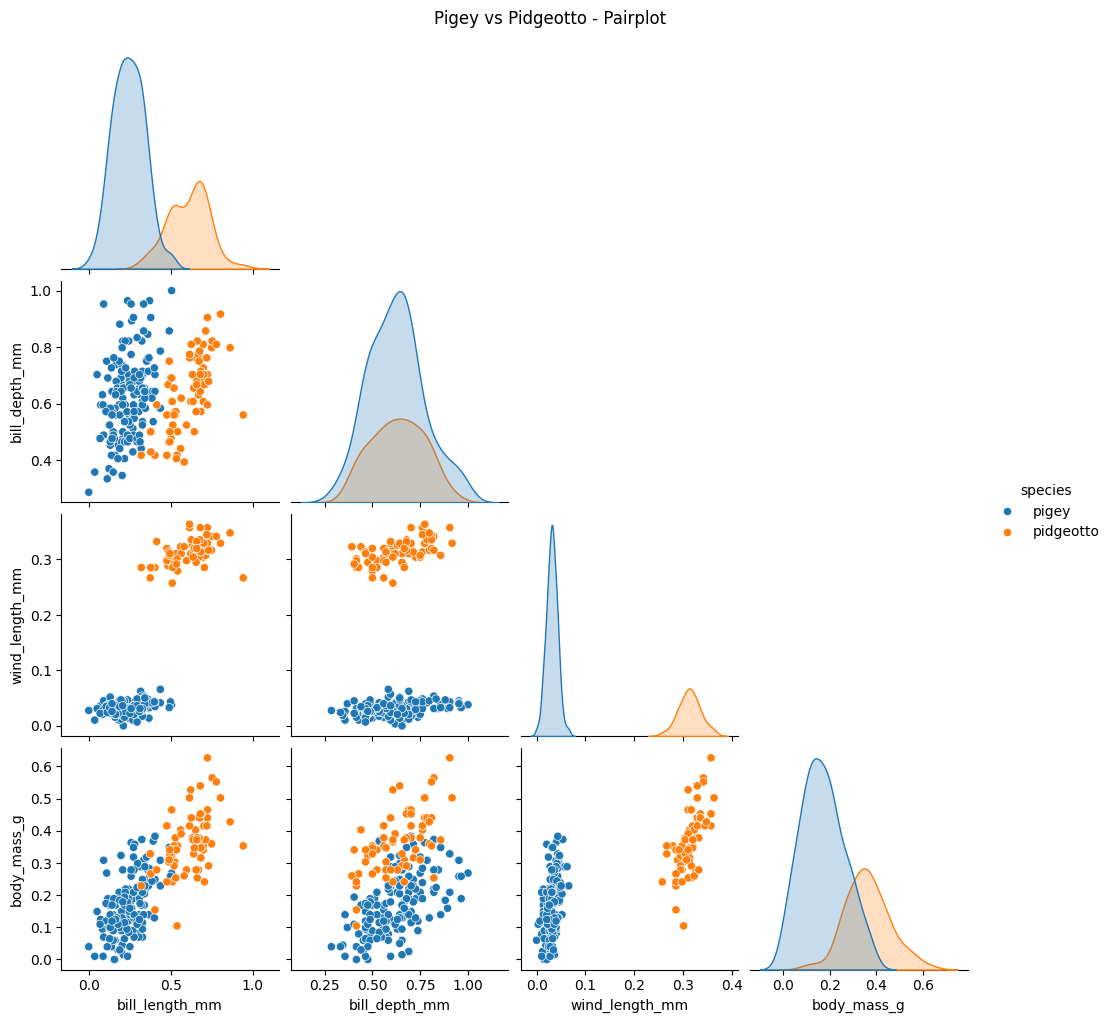

In [ ]:
# Pairplot graphic only with numeric features
sns.pairplot(df_pairplot[["bill_length_mm", "bill_depth_mm", "wind_length_mm", "body_mass_g", "species"]],
             hue="species",
             corner=True)

plt.suptitle("Pigey vs Pidgeotto - Pairplot", y=1.02)
plt.show()


In [ ]:
df_pairplot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219 entries, 0 to 219
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   species         219 non-null    object 
 1   bill_length_mm  219 non-null    float64
 2   bill_depth_mm   219 non-null    float64
 3   wind_length_mm  219 non-null    float64
 4   body_mass_g     219 non-null    float64
dtypes: float64(4), object(1)
memory usage: 10.3+ KB


###Define classes  (Step Function) and (Perceptron class)

In [ ]:
# Step activation function
class Step:
    def __init__(self, threshold=0):
        self.__threshold__ = threshold
    def transform(self, x):   # Returns 1 if x >= threshold, else 0 as see in class
        return tf.cast(x >= self.__threshold__, tf.int32)

# Perceptron
class Perceptron:
    def __init__(self, units, activation):
        self.weights = tf.Variable(tf.random.uniform([units, 1], minval=-1, maxval=1, dtype=tf.float32))   # Random weights between -1 and 1
        self.bias = tf.Variable(tf.zeros([1], dtype=tf.float32))   # Bias starts at 0
        self.activation = activation

    def predict(self, X):
        X = tf.cast(tf.reshape(X, [1, tf.shape(X)[0]]), dtype=tf.float32)
        linear_output = tf.add(tf.matmul(X, self.weights), self.bias)  # We calculate the output: (X · weights) + bias
        return self.activation.transform(linear_output)  # We apply activation function

    def fit(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            for i in range(X.shape[0]):
                sample = tf.cast(X[i], dtype=tf.float32)
                prediction = self.predict(sample)
                error = tf.cast(y[i], dtype=tf.float32) - tf.cast(prediction, dtype=tf.float32)   # Calculate the error
                dweights = learning_rate * tf.cast(error, tf.float32) * tf.reshape(sample, [tf.shape(sample)[0], 1])   # Update weights and bias (Same process as seen in class)
                dbias = tf.reshape(learning_rate * tf.cast(error, tf.float32), self.bias.shape)
                self.weights.assign_add(dweights)
                self.bias.assign_add(dbias)

                print(f"Epoch: {epoch + 1}, Iteration: {i + 1}, Input: {sample.numpy()}, Initial Weights: {self.weights.numpy().flatten() - dweights.numpy().flatten()}, y: {y[i]}, t: {prediction.numpy()[0][0]}, Error: {error.numpy()[0][0]}, Final Weights: {self.weights.numpy().flatten()}\n")

# **Comb 1: pigey vs pidgeotto (2 Features)**

In [ ]:
combinations = list(itertools.combinations(feature_cols, 2))

# List to store results
trained_models = []

# Train perceptron with each pair of features
for feat1, feat2 in combinations:
    print(f"\nTraining with features: {feat1} & {feat2}")

    data_x = df_comb1[[feat1, feat2]].values
    data_y = df_comb1["species"].values

    X_train = tf.convert_to_tensor(data_x, np.float32)
    y_train = tf.convert_to_tensor(data_y, np.float32)
    X_test = tf.convert_to_tensor(data_x, np.float32)
    y_test = tf.convert_to_tensor(data_y, np.float32)

    input_size = data_x.shape[1]
    learning_rate = 0.1
    epochs = 100

    perceptron = Perceptron(units=input_size, activation=Step())

    perceptron.fit(X_train, y_train, epochs=epochs, learning_rate=learning_rate)

    # Evaluate the model
    correct_predictions = 0
    for i in range(X_test.shape[0]):
        prediction = perceptron.predict(X_test[i])
        if prediction == tf.cast(y_test[i], tf.int32):
            correct_predictions += 1

    # Calculate accuracy and error
    accuracy = correct_predictions / X_test.shape[0]
    error = 1 - accuracy
    print(f"Accuracy: {accuracy:.4f} Error: {error:.4f}")

    # Save everything to use later in graphs, so it´s better organized.
    trained_models.append({
        "feat1": feat1,
        "feat2": feat2,
        "data_x": data_x,
        "data_y": data_y,
        "perceptron": perceptron,
        "accuracy": accuracy,
        "error": error
    })


Se han truncado las últimas 5000 líneas del flujo de salida.

Epoch: 89, Iteration: 130, Input: [0.03122615 0.09452736], Initial Weights: [0.2887714  0.18688543], y: 0.0, t: 0, Error: 0.0, Final Weights: [0.2887714  0.18688543]

Epoch: 89, Iteration: 131, Input: [0.04336965 0.12935324], Initial Weights: [0.2887714  0.18688543], y: 0.0, t: 0, Error: 0.0, Final Weights: [0.2887714  0.18688543]

Epoch: 89, Iteration: 132, Input: [0.0364305  0.12935324], Initial Weights: [0.2887714  0.18688543], y: 0.0, t: 0, Error: 0.0, Final Weights: [0.2887714  0.18688543]

Epoch: 89, Iteration: 133, Input: [0.04683922 0.3233831 ], Initial Weights: [0.2887714  0.18688543], y: 0.0, t: 0, Error: 0.0, Final Weights: [0.2887714  0.18688543]

Epoch: 89, Iteration: 134, Input: [0.02602179 0.11442786], Initial Weights: [0.2887714  0.18688543], y: 0.0, t: 0, Error: 0.0, Final Weights: [0.2887714  0.18688543]

Epoch: 89, Iteration: 135, Input: [0.03122615 0.20895523], Initial Weights: [0.2887714  0.18688543], y:

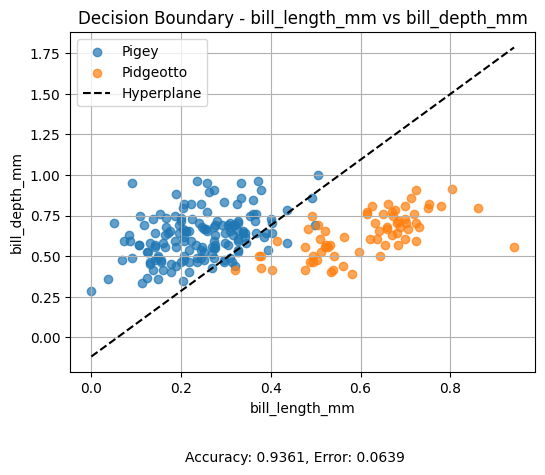

Hyperplane equation: 1.7187*x1 + -0.8507*x2 + -0.1000 = 0


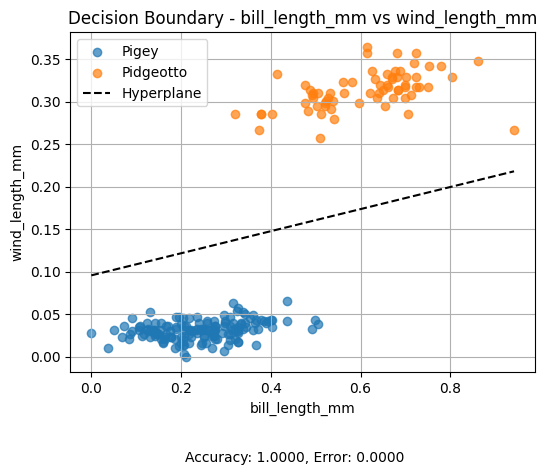

Hyperplane equation: -0.1361*x1 + 1.0472*x2 + -0.1000 = 0


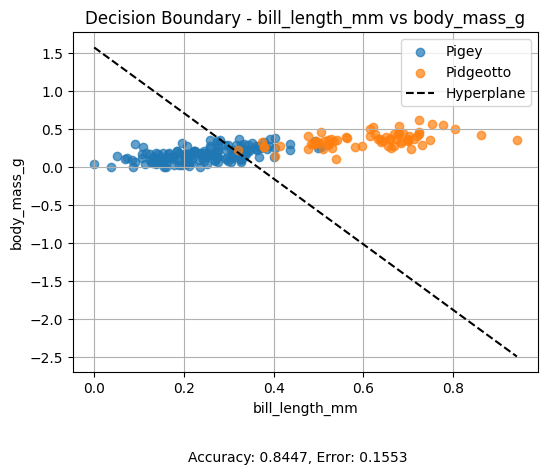

Hyperplane equation: 1.3695*x1 + 0.3175*x2 + -0.5000 = 0


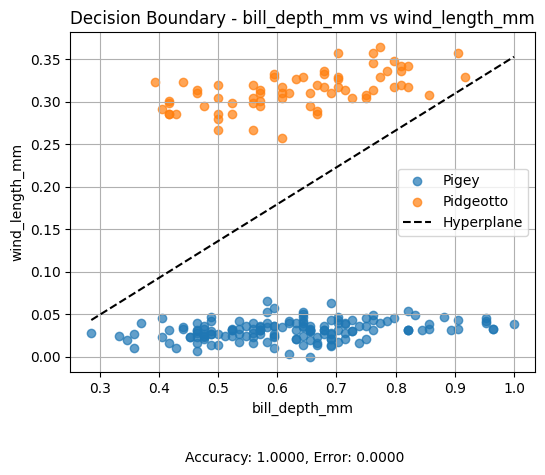

Hyperplane equation: -0.5357*x1 + 1.2354*x2 + 0.1000 = 0


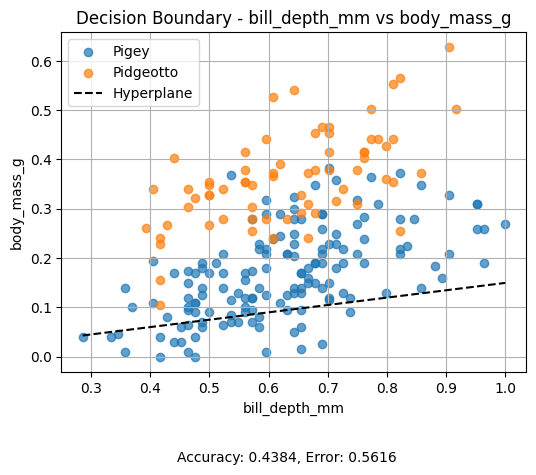

Hyperplane equation: -0.1729*x1 + 1.1575*x2 + -0.0000 = 0


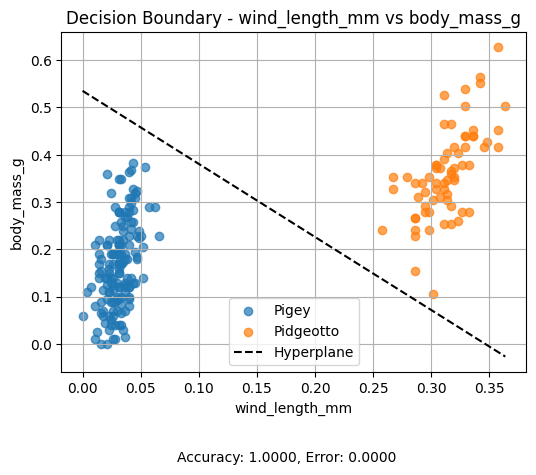

Hyperplane equation: 0.2888*x1 + 0.1869*x2 + -0.1000 = 0


In [ ]:
# Visual part

for model in trained_models:
    feat1 = model["feat1"]
    feat2 = model["feat2"]
    data_x = model["data_x"]
    data_y = model["data_y"]
    perceptron = model["perceptron"]
    accuracy = model["accuracy"]
    error = model["error"]

    weights = perceptron.weights.numpy()
    bias = perceptron.bias.numpy()

    def hyperplane(x1):
        return -(weights[0] * x1 + bias) / weights[1]

    plt.figure(figsize=(6, 5))
    plt.scatter(data_x[data_y == 0, 0], data_x[data_y == 0, 1], label="Pigey", alpha=0.7)
    plt.scatter(data_x[data_y == 1, 0], data_x[data_y == 1, 1], label="Pidgeotto", alpha=0.7)

    x1_vals = np.linspace(data_x[:, 0].min(), data_x[:, 0].max(), 100)
    x2_vals = hyperplane(x1_vals)

    plt.plot(x1_vals, x2_vals, 'k--', label='Hyperplane')
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(f"Decision Boundary - {feat1} vs {feat2}")
    plt.legend()
    plt.grid(True)

    plt.subplots_adjust(bottom=0.2)
    plt.figtext(0.5, 0.02, f"Accuracy: {accuracy:.4f}, Error: {error:.4f}", ha="center", fontsize=10)

    plt.show()

    print(f"Hyperplane equation: {weights[0][0]:.4f}*x1 + {weights[1][0]:.4f}*x2 + {bias[0]:.4f} = 0")

# **Comb 2: Pigey vs Pidgeot (2 Features)**


In [ ]:
combinations = list(itertools.combinations(feature_cols, 2))

# List to store results
trained_models_comb2 = []

# Train perceptron with each pair of features
for feat1, feat2 in combinations:
    print(f"\n Training with features: {feat1} & {feat2}")

    data_x = df_comb2[[feat1, feat2]].values
    data_y = df_comb2["species"].values

    X_train = tf.convert_to_tensor(data_x, np.float32)
    y_train = tf.convert_to_tensor(data_y, np.float32)
    X_test = tf.convert_to_tensor(data_x, np.float32)
    y_test = tf.convert_to_tensor(data_y, np.float32)

    input_size = data_x.shape[1]
    learning_rate = 0.1
    epochs = 100

    perceptron = Perceptron(units=input_size, activation=Step())
    perceptron.fit(X_train, y_train, epochs=epochs, learning_rate=learning_rate)

    # Evaluate the model
    correct_predictions = 0
    for i in range(X_test.shape[0]):
        prediction = perceptron.predict(X_test[i])
        if prediction == tf.cast(y_test[i], tf.int32):
            correct_predictions += 1

    # Calculate accuracy and error
    accuracy = correct_predictions / X_test.shape[0]
    error = 1 - accuracy
    print(f"Accuracy: {accuracy:.4f} Error: {error:.4f}")

    # Save everything to use later in graphs, so it´s better organized.
    trained_models_comb2.append({
        "feat1": feat1,
        "feat2": feat2,
        "data_x": data_x,
        "data_y": data_y,
        "perceptron": perceptron,
        "accuracy": accuracy,
        "error": error
    })

Se han truncado las últimas 5000 líneas del flujo de salida.

Epoch: 91, Iteration: 242, Input: [0.92693084 0.6641791 ], Initial Weights: [ 0.99395776 -0.6159757 ], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.99395776 -0.6159757 ]

Epoch: 91, Iteration: 243, Input: [0.9831379 0.7761194], Initial Weights: [ 0.99395776 -0.6159757 ], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.99395776 -0.6159757 ]

Epoch: 91, Iteration: 244, Input: [0.8932066  0.61442786], Initial Weights: [ 0.99395776 -0.6159757 ], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.99395776 -0.6159757 ]

Epoch: 91, Iteration: 245, Input: [0.96065503 0.83830845], Initial Weights: [ 0.99395776 -0.6159757 ], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.99395776 -0.6159757 ]

Epoch: 91, Iteration: 246, Input: [0.904448  0.6393035], Initial Weights: [ 0.99395776 -0.6159757 ], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.99395776 -0.6159757 ]

Epoch: 91, Iteration: 247, Input: [0.97189647 0.7263682 ], Initial Weights: [ 0.9939577

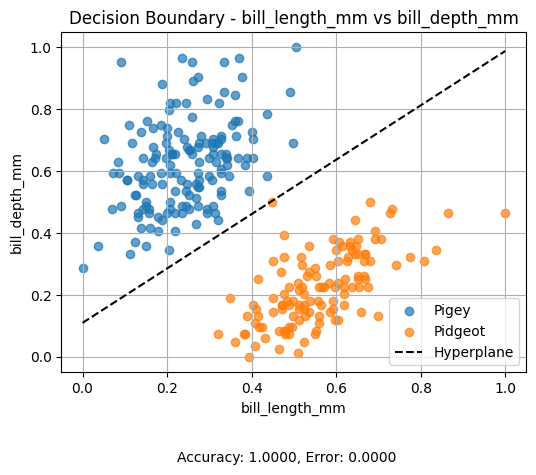

Hyperplane equation: 0.8064*x1 + -0.9169*x2 + 0.1000 = 0


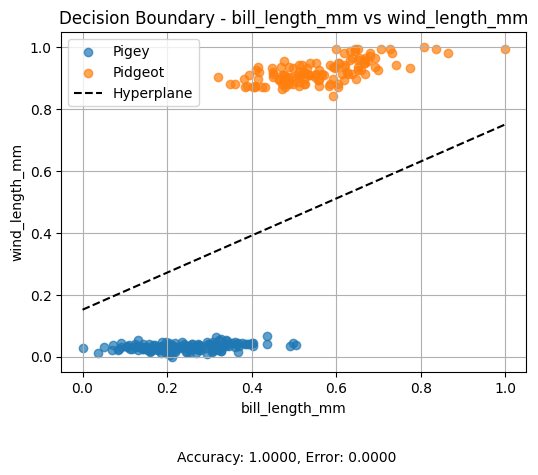

Hyperplane equation: -0.3954*x1 + 0.6596*x2 + -0.1000 = 0


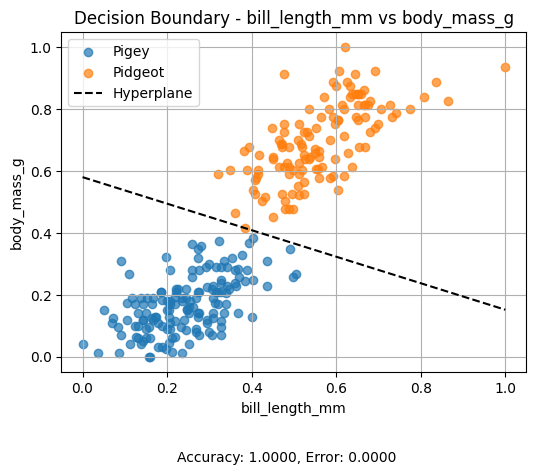

Hyperplane equation: 0.5174*x1 + 1.2060*x2 + -0.7000 = 0


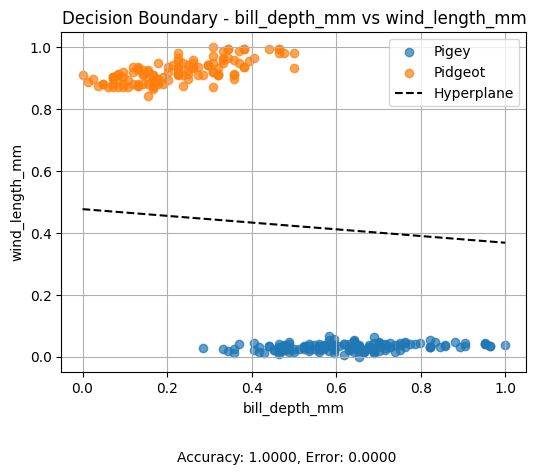

Hyperplane equation: 0.0228*x1 + 0.2097*x2 + -0.1000 = 0


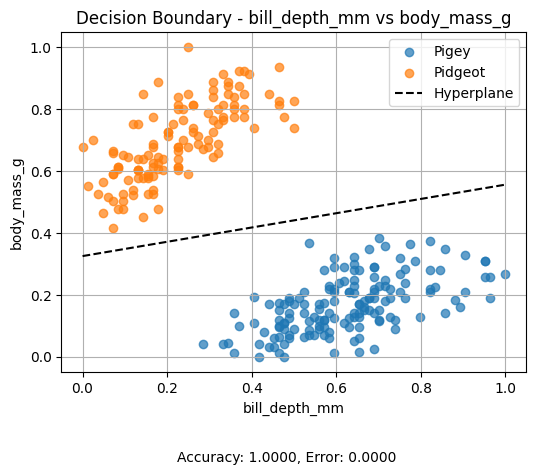

Hyperplane equation: -0.2133*x1 + 0.9230*x2 + -0.3000 = 0


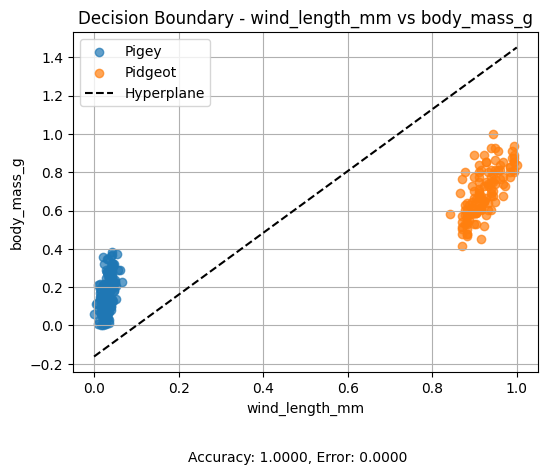

Hyperplane equation: 0.9940*x1 + -0.6160*x2 + -0.1000 = 0


In [ ]:
# Visual part

for model in trained_models_comb2:
    feat1 = model["feat1"]
    feat2 = model["feat2"]
    data_x = model["data_x"]
    data_y = model["data_y"]
    perceptron = model["perceptron"]
    accuracy = model["accuracy"]
    error = model["error"]

    weights = perceptron.weights.numpy()
    bias = perceptron.bias.numpy()

    def hyperplane(x1):
        return -(weights[0] * x1 + bias) / weights[1]

    plt.figure(figsize=(6, 5))
    plt.scatter(data_x[data_y == 0, 0], data_x[data_y == 0, 1], label="Pigey", alpha=0.7)
    plt.scatter(data_x[data_y == 1, 0], data_x[data_y == 1, 1], label="Pidgeot", alpha=0.7)

    x1_vals = np.linspace(data_x[:, 0].min(), data_x[:, 0].max(), 100)
    x2_vals = hyperplane(x1_vals)

    plt.plot(x1_vals, x2_vals, 'k--', label='Hyperplane')
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(f"Decision Boundary - {feat1} vs {feat2}")
    plt.legend()
    plt.grid(True)

    plt.subplots_adjust(bottom=0.2)
    plt.figtext(0.5, 0.02, f"Accuracy: {accuracy:.4f}, Error: {error:.4f}", ha="center", fontsize=10)

    plt.show()

    print(f"Hyperplane equation: {weights[0][0]:.4f}*x1 + {weights[1][0]:.4f}*x2 + {bias[0]:.4f} = 0")

# **Comb 3: Pidgeotto vs Pidgeot (2 Features)**

In [ ]:
combinations = list(itertools.combinations(feature_cols, 2))

# List to store results
trained_models_comb3 = []

# Train perceptron with each pair of features
for feat1, feat2 in combinations:
    print(f"\n Training with features: {feat1} & {feat2}")

    data_x = df_comb3[[feat1, feat2]].values
    data_y = df_comb3["species"].values

    X_train = tf.convert_to_tensor(data_x, np.float32)
    y_train = tf.convert_to_tensor(data_y, np.float32)
    X_test = tf.convert_to_tensor(data_x, np.float32)
    y_test = tf.convert_to_tensor(data_y, np.float32)

    input_size = data_x.shape[1]
    learning_rate = 0.1
    epochs = 100

    perceptron = Perceptron(units=input_size, activation=Step())
    perceptron.fit(X_train, y_train, epochs=epochs, learning_rate=learning_rate)

    # Evaluate the model
    correct_predictions = 0
    for i in range(X_test.shape[0]):
        prediction = perceptron.predict(X_test[i])
        if prediction == tf.cast(y_test[i], tf.int32):
            correct_predictions += 1

    # Calculate accuracy and error
    accuracy = correct_predictions / X_test.shape[0]
    error = 1 - accuracy
    print(f"Accuracy: {accuracy:.4f} Error: {error:.4f}")

    # Save everything to use later in graphs, so it´s better organized.
    trained_models_comb3.append({
        "feat1": feat1,
        "feat2": feat2,
        "data_x": data_x,
        "data_y": data_y,
        "perceptron": perceptron,
        "accuracy": accuracy,
        "error": error
    })

Se han truncado las últimas 5000 líneas del flujo de salida.

Epoch: 87, Iteration: 176, Input: [0.9325515  0.80099505], Initial Weights: [ 0.6515266  -0.34245485], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.6515266  -0.34245485]

Epoch: 87, Iteration: 177, Input: [0.8707237 0.5708955], Initial Weights: [ 0.6515266  -0.34245485], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.6515266  -0.34245485]

Epoch: 87, Iteration: 178, Input: [0.87634444 0.80099505], Initial Weights: [ 0.6515266  -0.34245485], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.6515266  -0.34245485]

Epoch: 87, Iteration: 179, Input: [0.9156894 0.6766169], Initial Weights: [ 0.6515266  -0.34245485], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.6515266  -0.34245485]

Epoch: 87, Iteration: 180, Input: [0.98875856 0.9129353 ], Initial Weights: [ 0.6515266  -0.34245485], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.6515266  -0.34245485]

Epoch: 87, Iteration: 181, Input: [0.8988273 0.5895522], Initial Weights: [ 0.6515266  

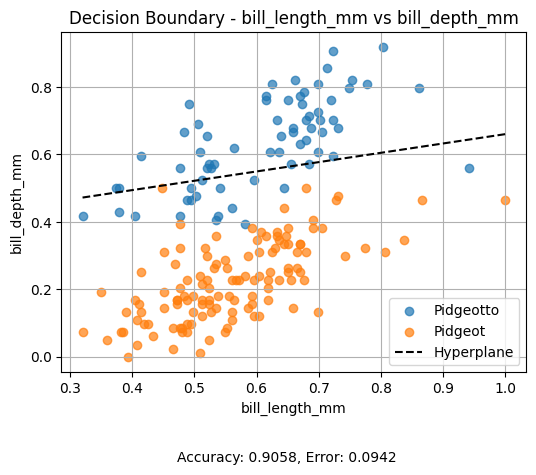

Hyperplane equation: 0.2888*x1 + -1.0443*x2 + 0.4000 = 0


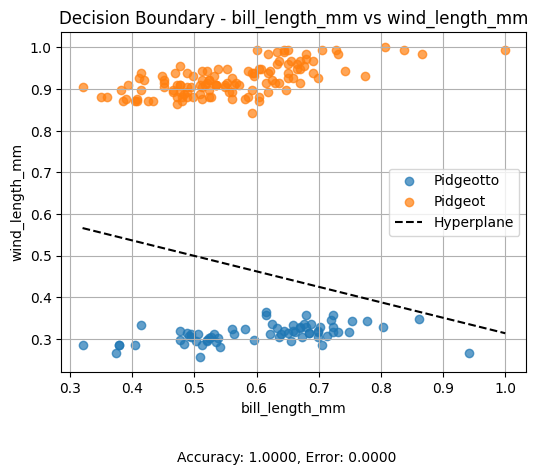

Hyperplane equation: 0.1627*x1 + 0.4379*x2 + -0.3000 = 0


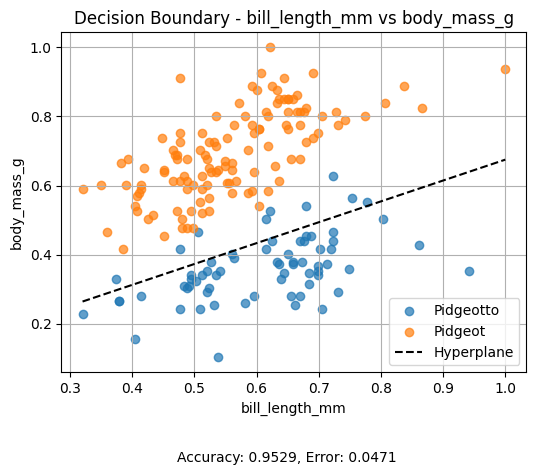

Hyperplane equation: -0.8584*x1 + 1.4199*x2 + -0.1000 = 0


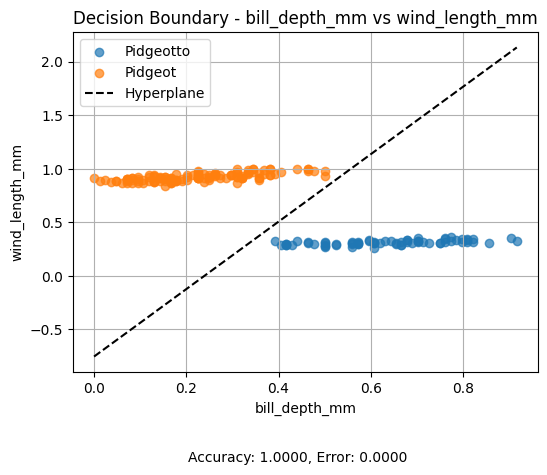

Hyperplane equation: -0.8357*x1 + 0.2654*x2 + 0.2000 = 0


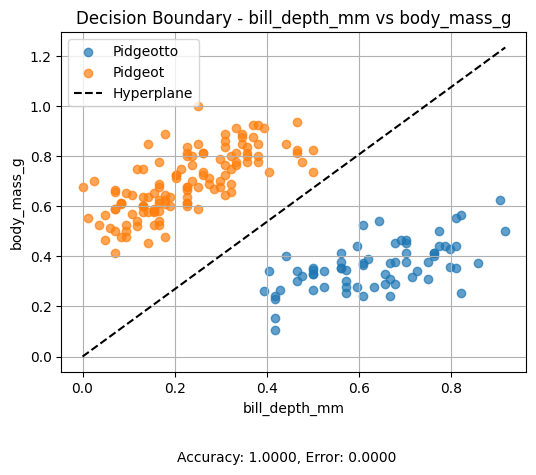

Hyperplane equation: -0.3728*x1 + 0.2767*x2 + 0.0000 = 0


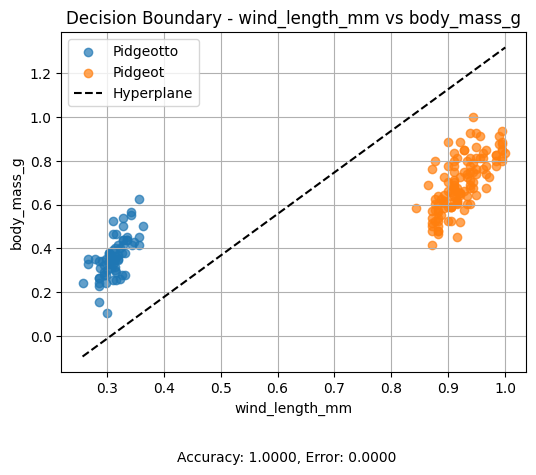

Hyperplane equation: 0.6515*x1 + -0.3425*x2 + -0.2000 = 0


In [ ]:
# Visual part

for model in trained_models_comb3:
    feat1 = model["feat1"]
    feat2 = model["feat2"]
    data_x = model["data_x"]
    data_y = model["data_y"]
    perceptron = model["perceptron"]
    accuracy = model["accuracy"]
    error = model["error"]

    weights = perceptron.weights.numpy()
    bias = perceptron.bias.numpy()

    def hyperplane(x1):
        return -(weights[0] * x1 + bias) / weights[1]

    plt.figure(figsize=(6, 5))
    plt.scatter(data_x[data_y == 0, 0], data_x[data_y == 0, 1], label="Pidgeotto", alpha=0.7)
    plt.scatter(data_x[data_y == 1, 0], data_x[data_y == 1, 1], label="Pidgeot", alpha=0.7)

    x1_vals = np.linspace(data_x[:, 0].min(), data_x[:, 0].max(), 100)
    x2_vals = hyperplane(x1_vals)

    plt.plot(x1_vals, x2_vals, 'k--', label='Hyperplane')
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(f"Decision Boundary - {feat1} vs {feat2}")
    plt.legend()
    plt.grid(True)

    plt.figtext(0.5, 0.02, f"Accuracy: {accuracy:.4f}, Error: {error:.4f}", ha="center", fontsize=10)
    plt.subplots_adjust(bottom=0.2)

    plt.show()

    print(f"Hyperplane equation: {weights[0][0]:.4f}*x1 + {weights[1][0]:.4f}*x2 + {bias[0]:.4f} = 0")


# **Comb 4: Pigey vs Pidgeotto (3 Features)**

In [ ]:
combinations_3 = list(itertools.combinations(feature_cols, 3))

# List to store results
trained_models_3d = []

# Train perceptron with each pair of features
for feat1, feat2, feat3 in combinations_3:
    print(f"\n Training with features: {feat1}, {feat2}, {feat3}")

    data_x = df_comb1[[feat1, feat2, feat3]].values
    data_y = df_comb1["species"].values

    X_train = tf.convert_to_tensor(data_x, dtype=tf.float32)
    y_train = tf.convert_to_tensor(data_y, dtype=tf.float32)
    X_test = tf.convert_to_tensor(data_x, dtype=tf.float32)
    y_test = tf.convert_to_tensor(data_y, dtype=tf.float32)

    input_size = data_x.shape[1]
    learning_rate = 0.1
    epochs = 100

    perceptron = Perceptron(units=input_size, activation=Step())
    perceptron.fit(X_train, y_train, epochs=epochs, learning_rate=learning_rate)

    # Evaluate the model
    correct_predictions = 0
    for i in range(X_test.shape[0]):
        prediction = perceptron.predict(X_test[i])
        if prediction == tf.cast(y_test[i], tf.int32):
            correct_predictions += 1

    # Calculate accuracy and error
    accuracy = correct_predictions / X_test.shape[0]
    error = 1 - accuracy
    print(f" Accuracy: {accuracy:.4f} Error: {error:.4f}")

    # Save everything to use later in graphs, so it´s better organized.
    trained_models_3d.append({
        "feat1": feat1,
        "feat2": feat2,
        "feat3": feat3,
        "data_x": data_x,
        "data_y": data_y,
        "perceptron": perceptron,
        "accuracy": accuracy,
        "error": error
    })


Se han truncado las últimas 5000 líneas del flujo de salida.

Epoch: 89, Iteration: 130, Input: [0.5714286  0.03122615 0.09452736], Initial Weights: [ 0.18917549  0.5820625  -0.04972721], y: 0.0, t: 0, Error: 0.0, Final Weights: [ 0.18917549  0.5820625  -0.04972721]

Epoch: 89, Iteration: 131, Input: [0.72619045 0.04336965 0.12935324], Initial Weights: [ 0.18917549  0.5820625  -0.04972721], y: 0.0, t: 0, Error: 0.0, Final Weights: [ 0.18917549  0.5820625  -0.04972721]

Epoch: 89, Iteration: 132, Input: [0.64285713 0.0364305  0.12935324], Initial Weights: [ 0.18917549  0.5820625  -0.04972721], y: 0.0, t: 0, Error: 0.0, Final Weights: [ 0.18917549  0.5820625  -0.04972721]

Epoch: 89, Iteration: 133, Input: [0.64285713 0.04683922 0.3233831 ], Initial Weights: [ 0.18917549  0.5820625  -0.04972721], y: 0.0, t: 0, Error: 0.0, Final Weights: [ 0.18917549  0.5820625  -0.04972721]

Epoch: 89, Iteration: 134, Input: [0.53571427 0.02602179 0.11442786], Initial Weights: [ 0.18917549  0.5820625  -0

In [ ]:
#Visual Part

for model in trained_models_3d:
    feat1 = model["feat1"]
    feat2 = model["feat2"]
    feat3 = model["feat3"]
    data_x = model["data_x"]
    data_y = model["data_y"]
    perceptron = model["perceptron"]
    accuracy = model["accuracy"]
    error = model["error"]

    weights = perceptron.weights.numpy()
    bias = perceptron.bias.numpy()

    x1_range = np.linspace(data_x[:, 0].min(), data_x[:, 0].max(), 10)
    x2_range = np.linspace(data_x[:, 1].min(), data_x[:, 1].max(), 10)
    x1, x2 = np.meshgrid(x1_range, x2_range)
    x3 = -(weights[0] * x1 + weights[1] * x2 + bias) / weights[2]

    fig = go.Figure(data=[
        go.Scatter3d(
            x=data_x[data_y == 0, 0],
            y=data_x[data_y == 0, 1],
            z=data_x[data_y == 0, 2],
            mode='markers',
            marker=dict(size=4, color='blue'),
            name='Pigey'
        ),
        go.Scatter3d(
            x=data_x[data_y == 1, 0],
            y=data_x[data_y == 1, 1],
            z=data_x[data_y == 1, 2],
            mode='markers',
            marker=dict(size=4, color='orange'),
            name='Pidgeotto'
        ),
        go.Surface(
            x=x1,
            y=x2,
            z=x3,
            opacity=0.5,
            colorscale='Greens',
            showscale=False,
            name='Hyperplane'
        )
    ])

    fig.update_layout(
        title={
            "text": f"Decision Boundary (3D) - {feat1}, {feat2}, {feat3}<br>"
                    f"<span style='font-size:12px'>Accuracy: {accuracy:.4f}, Error: {error:.4f}</span>",
            "x": 0.5
        },
        scene=dict(
            xaxis_title=feat1,
            yaxis_title=feat2,
            zaxis_title=feat3,
        ),
        margin=dict(l=0, r=0, b=0, t=50)
    )

    fig.show()

    print(f"Hyperplane equation: {weights[0][0]:.4f}*x1 + {weights[1][0]:.4f}*x2 + {weights[2][0]:.4f}*x3 + {bias[0]:.4f} = 0")


Hyperplane equation: -0.1608*x1 + 0.0574*x2 + 0.9135*x3 + -0.1000 = 0


Hyperplane equation: 0.9650*x1 + -0.7907*x2 + 0.7694*x3 + -0.1000 = 0


Hyperplane equation: 0.5519*x1 + 0.4918*x2 + -0.0585*x3 + -0.3000 = 0


Hyperplane equation: 0.1892*x1 + 0.5821*x2 + -0.0497*x3 + -0.2000 = 0


# **Comb 5: Pidgey vs Pidgeot (3 Features)**

In [ ]:
combinations = list(itertools.combinations(feature_cols, 3))

# List to store results
trained_models_3d_comb2 = []

# Train perceptron with each pair of features
for feat1, feat2, feat3 in combinations:
    print(f"\n Training with features: {feat1}, {feat2}, {feat3}")

    data_x = df_comb2[[feat1, feat2, feat3]].values
    data_y = df_comb2["species"].values

    X_train = tf.convert_to_tensor(data_x, tf.float32)
    y_train = tf.convert_to_tensor(data_y, tf.float32)

    X_test = tf.convert_to_tensor(data_x, tf.float32)
    y_test = tf.convert_to_tensor(data_y, tf.float32)

    input_size = data_x.shape[1]
    learning_rate = 0.1
    epochs = 100

    perceptron = Perceptron(units=input_size, activation=Step())
    perceptron.fit(X_train, y_train, epochs=epochs, learning_rate=learning_rate)

    # Evaluate the model
    correct_predictions = 0
    for i in range(X_test.shape[0]):
        prediction = perceptron.predict(X_test[i])
        if prediction == tf.cast(y_test[i], tf.int32):
            correct_predictions += 1

    # Calculate accuracy and error
    accuracy = correct_predictions / X_test.shape[0]
    error = 1 - accuracy
    print(f" Accuracy: {accuracy:.4f}, Error: {error:.4f}")

    # Save everything to use later in graphs, so it´s better organized.
    trained_models_3d_comb2.append({
        "feat1": feat1,
        "feat2": feat2,
        "feat3": feat3,
        "data_x": data_x,
        "data_y": data_y,
        "perceptron": perceptron,
        "accuracy": accuracy,
        "error": error
    })


Se han truncado las últimas 5000 líneas del flujo de salida.

Epoch: 91, Iteration: 242, Input: [0.22619048 0.92693084 0.6641791 ], Initial Weights: [0.30474102 0.5102892  0.21907006], y: 1.0, t: 1, Error: 0.0, Final Weights: [0.30474102 0.5102892  0.21907006]

Epoch: 91, Iteration: 243, Input: [0.47619048 0.9831379  0.7761194 ], Initial Weights: [0.30474102 0.5102892  0.21907006], y: 1.0, t: 1, Error: 0.0, Final Weights: [0.30474102 0.5102892  0.21907006]

Epoch: 91, Iteration: 244, Input: [0.16666667 0.8932066  0.61442786], Initial Weights: [0.30474102 0.5102892  0.21907006], y: 1.0, t: 1, Error: 0.0, Final Weights: [0.30474102 0.5102892  0.21907006]

Epoch: 91, Iteration: 245, Input: [0.35714287 0.96065503 0.83830845], Initial Weights: [0.30474102 0.5102892  0.21907006], y: 1.0, t: 1, Error: 0.0, Final Weights: [0.30474102 0.5102892  0.21907006]

Epoch: 91, Iteration: 246, Input: [0.1904762 0.904448  0.6393035], Initial Weights: [0.30474102 0.5102892  0.21907006], y: 1.0, t: 1, Erro

In [ ]:
#Visual Part

for model in trained_models_3d_comb2:
    feat1 = model["feat1"]
    feat2 = model["feat2"]
    feat3 = model["feat3"]
    data_x = model["data_x"]
    data_y = model["data_y"]
    perceptron = model["perceptron"]
    accuracy = model["accuracy"]
    error = model["error"]

    weights = perceptron.weights.numpy()
    bias = perceptron.bias.numpy()

    x_range = np.linspace(data_x[:, 0].min(), data_x[:, 0].max(), 10)
    y_range = np.linspace(data_x[:, 1].min(), data_x[:, 1].max(), 10)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    z_grid = -(weights[0] * x_grid + weights[1] * y_grid + bias) / weights[2]

    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=data_x[data_y == 0, 0],
        y=data_x[data_y == 0, 1],
        z=data_x[data_y == 0, 2],
        mode='markers',
        marker=dict(size=4, color='blue'),
        name='Pigey'
    ))
    fig.add_trace(go.Scatter3d(
        x=data_x[data_y == 1, 0],
        y=data_x[data_y == 1, 1],
        z=data_x[data_y == 1, 2],
        mode='markers',
        marker=dict(size=4, color='green'),
        name='Pidgeot'
    ))
    fig.add_trace(go.Surface(
        x=x_grid,
        y=y_grid,
        z=z_grid,
        opacity=0.5,
        showscale=False,
        name='Hyperplane'
    ))

    fig.update_layout(
        title={
            "text": f"Decision Hyperplane - {feat1}, {feat2}, {feat3}<br>"
                    f"<span style='font-size:12px'>Accuracy: {accuracy:.4f}, Error: {error:.4f}</span>",
            "x": 0.5
        },
        scene=dict(
            xaxis_title=feat1,
            yaxis_title=feat2,
            zaxis_title=feat3,
        ),
        margin=dict(l=0, r=0, b=0, t=50)
    )

    fig.show()

    print(f"Hyperplane equation: {weights[0][0]:.4f}*x1 + {weights[1][0]:.4f}*x2 + {weights[2][0]:.4f}*x3 + {bias[0]:.4f} = 0")


Hyperplane equation: 0.1319*x1 + -0.1027*x2 + 0.4000*x3 + -0.1000 = 0


Hyperplane equation: 0.0979*x1 + -0.5740*x2 + 0.1968*x3 + 0.1000 = 0


Hyperplane equation: -0.1278*x1 + 0.5806*x2 + -0.4589*x3 + 0.0000 = 0


Hyperplane equation: 0.3047*x1 + 0.5103*x2 + 0.2191*x3 + -0.5000 = 0


# **Comb 6: Pidgeotto vs Pidgeot (3 Features)**

In [ ]:
combinations_3d = list(itertools.combinations(feature_cols, 3))

# List to store results
trained_models_3d_comb3 = []

# Train perceptron with each pair of features
for feat1, feat2, feat3 in combinations_3d:
    print(f"\n Training with features: {feat1}, {feat2}, {feat3}")

    data_x = df_comb3[[feat1, feat2, feat3]].values
    data_y = df_comb3["species"].values

    X_train = tf.convert_to_tensor(data_x, dtype=tf.float32)
    y_train = tf.convert_to_tensor(data_y, dtype=tf.float32)
    X_test = tf.convert_to_tensor(data_x, dtype=tf.float32)
    y_test = tf.convert_to_tensor(data_y, dtype=tf.float32)

    input_size = data_x.shape[1]
    learning_rate = 0.1
    epochs = 100

    perceptron = Perceptron(units=input_size, activation=Step())
    perceptron.fit(X_train, y_train, epochs=epochs, learning_rate=learning_rate)

    # Evaluate the model
    correct_predictions = 0
    for i in range(X_test.shape[0]):
        prediction = perceptron.predict(X_test[i])
        if prediction == tf.cast(y_test[i], tf.int32):
            correct_predictions += 1

    # Calculate accuracy and error
    accuracy = correct_predictions / X_test.shape[0]
    error = 1 - accuracy
    print(f" Accuracy: {accuracy:.4f}, Error: {error:.4f}")

    # Save everything to use later in graphs, so it´s better organized.
    trained_models_3d_comb3.append({
        "feat1": feat1,
        "feat2": feat2,
        "feat3": feat3,
        "data_x": data_x,
        "data_y": data_y,
        "perceptron": perceptron,
        "accuracy": accuracy,
        "error": error
    })


Se han truncado las últimas 5000 líneas del flujo de salida.

Epoch: 87, Iteration: 176, Input: [0.32142857 0.9325515  0.80099505], Initial Weights: [ 0.26768744  0.7740467  -0.2850857 ], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.26768744  0.7740467  -0.2850857 ]

Epoch: 87, Iteration: 177, Input: [0.10714286 0.8707237  0.5708955 ], Initial Weights: [ 0.26768744  0.7740467  -0.2850857 ], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.26768744  0.7740467  -0.2850857 ]

Epoch: 87, Iteration: 178, Input: [0.23809524 0.87634444 0.80099505], Initial Weights: [ 0.26768744  0.7740467  -0.2850857 ], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.26768744  0.7740467  -0.2850857 ]

Epoch: 87, Iteration: 179, Input: [0.25      0.9156894 0.6766169], Initial Weights: [ 0.26768744  0.7740467  -0.2850857 ], y: 1.0, t: 1, Error: 0.0, Final Weights: [ 0.26768744  0.7740467  -0.2850857 ]

Epoch: 87, Iteration: 180, Input: [0.33333334 0.98875856 0.9129353 ], Initial Weights: [ 0.26768744  0.7740467  -0.28

In [ ]:
#Visual Part

for model in trained_models_3d_comb3:
    feat1 = model["feat1"]
    feat2 = model["feat2"]
    feat3 = model["feat3"]
    data_x = model["data_x"]
    data_y = model["data_y"]
    perceptron = model["perceptron"]
    accuracy = model["accuracy"]
    error = model["error"]

    weights = perceptron.weights.numpy()
    bias = perceptron.bias.numpy()

    x_range = np.linspace(data_x[:, 0].min(), data_x[:, 0].max(), 10)
    y_range = np.linspace(data_x[:, 1].min(), data_x[:, 1].max(), 10)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    z_grid = -(weights[0] * x_grid + weights[1] * y_grid + bias) / weights[2]

    fig = go.Figure(data=[
        go.Scatter3d(
            x=data_x[data_y == 0, 0],
            y=data_x[data_y == 0, 1],
            z=data_x[data_y == 0, 2],
            mode='markers',
            marker=dict(size=4, color='blue'),
            name='Pidgeotto'
        ),
        go.Scatter3d(
            x=data_x[data_y == 1, 0],
            y=data_x[data_y == 1, 1],
            z=data_x[data_y == 1, 2],
            mode='markers',
            marker=dict(size=4, color='green'),
            name='Pidgeot'
        ),
        go.Surface(
            x=x_grid,
            y=y_grid,
            z=z_grid,
            opacity=0.5,
            colorscale='Greys',
            showscale=False,
            name='Hyperplane'
        )
    ])

    fig.update_layout(
        title={
            "text": f"Decision Boundary (3D) – {feat1}, {feat2}, {feat3}<br>"
                    f"<span style='font-size:12px'>Accuracy: {accuracy:.4f}, Error: {error:.4f}</span>",
            "x": 0.5
        },
        scene=dict(
            xaxis_title=feat1,
            yaxis_title=feat2,
            zaxis_title=feat3
        ),
        legend=dict(x=0.8, y=0.9),
        margin=dict(l=0, r=0, b=0, t=50)
    )

    fig.show()

    print(f"Hyperplane equation: {weights[0][0]:.4f}*x1 + {weights[1][0]:.4f}*x2 + {weights[2][0]:.4f}*x3 + {bias[0]:.4f} = 0")


Hyperplane equation: 0.2951*x1 + -0.2372*x2 + 0.4325*x3 + -0.3000 = 0


Hyperplane equation: 0.3149*x1 + -0.4933*x2 + 0.6241*x3 + -0.3000 = 0


Hyperplane equation: -0.4845*x1 + 0.2871*x2 + 0.4958*x3 + -0.2000 = 0


Hyperplane equation: 0.2677*x1 + 0.7740*x2 + -0.2851*x3 + -0.4000 = 0


# **Comb 7: Pigey vs Pidgeotto (4 Features)**

In [ ]:
data_x = df_comb1[feature_cols].values
data_y = df_comb1["species"].values

# Apply MinMaxScaler
scaler = MinMaxScaler()
data_x = scaler.fit_transform(data_x)

# --- PCA with 2 components ---
pca_2 = PCA(n_components=2)
data_x_pca_2 = pca_2.fit_transform(data_x)

X_train_2 = tf.convert_to_tensor(data_x_pca_2, dtype=tf.float32)
y_train = tf.convert_to_tensor(data_y, dtype=tf.int32)
X_test_2 = tf.convert_to_tensor(data_x_pca_2, dtype=tf.float32)
y_test = tf.convert_to_tensor(data_y, dtype=tf.int32)

# Train and evaluate with 2 components
perceptron_2 = Perceptron(units=2, activation=Step())
perceptron_2.fit(X_train_2, y_train, epochs=100, learning_rate=0.1)

correct_predictions_2 = 0
for i in range(X_test_2.shape[0]):
    prediction = perceptron_2.predict(X_test_2[i])
    if prediction == tf.cast(y_test[i], tf.int32):
        correct_predictions_2 += 1

accuracy_2 = correct_predictions_2 / X_test_2.shape[0]
error_2 = 1 - accuracy_2
print(f" Accuracy (2 components): {accuracy_2:.4f} Error: {error_2:.4f}")


# --- PCA with 3 components ---
pca_3 = PCA(n_components=3)
data_x_pca_3 = pca_3.fit_transform(data_x)

X_train_3 = tf.convert_to_tensor(data_x_pca_3, dtype=tf.float32)
X_test_3 = tf.convert_to_tensor(data_x_pca_3, dtype=tf.float32)

# Train and evaluate with 3 components
perceptron_3 = Perceptron(units=3, activation=Step())
perceptron_3.fit(X_train_3, y_train, epochs=100, learning_rate=0.1)

correct_predictions_3 = 0
for i in range(X_test_3.shape[0]):
    prediction = perceptron_3.predict(X_test_3[i])
    if prediction == tf.cast(y_test[i], tf.int32):
        correct_predictions_3 += 1

accuracy_3 = correct_predictions_3 / X_test_3.shape[0]
error_3 = 1 - accuracy_3
print(f" Accuracy (3 components): {accuracy_3:.4f} Error: {error_3:.4f}")

Se han truncado las últimas 5000 líneas del flujo de salida.

Epoch: 89, Iteration: 130, Input: [-0.34301493 -0.07199338 -0.05871228], Initial Weights: [ 0.8191534 -0.6549656  0.7988581], y: 0, t: 0, Error: 0.0, Final Weights: [ 0.8191534 -0.6549656  0.7988581]

Epoch: 89, Iteration: 131, Input: [-0.19227393  0.14097492 -0.1161681 ], Initial Weights: [ 0.8191534 -0.6549656  0.7988581], y: 0, t: 0, Error: 0.0, Final Weights: [ 0.8191534 -0.6549656  0.7988581]

Epoch: 89, Iteration: 132, Input: [-0.32857555  0.02499969 -0.06277043], Initial Weights: [ 0.8191534 -0.6549656  0.7988581], y: 0, t: 0, Error: 0.0, Final Weights: [ 0.8191534 -0.6549656  0.7988581]

Epoch: 89, Iteration: 133, Input: [-0.17202207  0.11880416  0.18277438], Initial Weights: [ 0.8191534 -0.6549656  0.7988581], y: 0, t: 0, Error: 0.0, Final Weights: [ 0.8191534 -0.6549656  0.7988581]

Epoch: 89, Iteration: 134, Input: [-0.3541213  -0.10250908 -0.0058603 ], Initial Weights: [ 0.8191534 -0.6549656  0.7988581], y: 0, t:

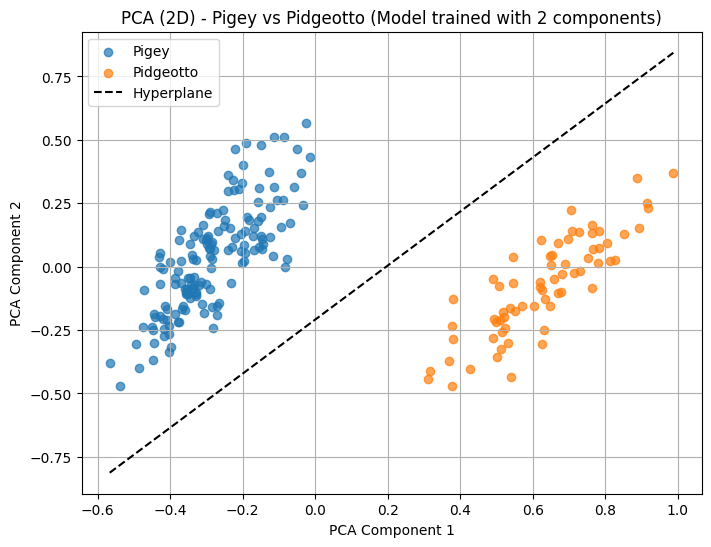

Accuracy (2 components): 1.0000, Error: 0.0000
Hyperplane equation: 0.5100*x1 + -0.4786*x2 + -0.1000 = 0


In [ ]:
# --- Visualization for PCA with 2 components ---
plt.figure(figsize=(8, 6))

# Scatter plot of data points
plt.scatter(data_x_pca_2[data_y == 0, 0], data_x_pca_2[data_y == 0, 1], label="Pigey", alpha=0.7)
plt.scatter(data_x_pca_2[data_y == 1, 0], data_x_pca_2[data_y == 1, 1], label="Pidgeotto", alpha=0.7)

plt.title("PCA (2D) - Pigey vs Pidgeotto (Model trained with 2 components)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)

# Get PCA components and perceptron weights
V_2 = pca_2.components_
w_2 = perceptron_2.weights.numpy().flatten()
b_2 = perceptron_2.bias.numpy()[0]

def hyperplane_pca_2(pc1):
    return -(w_2[0] * pc1 + b_2) / w_2[1]

x_vals_2 = np.linspace(data_x_pca_2[:, 0].min(), data_x_pca_2[:, 0].max(), 100)
y_vals_2 = hyperplane_pca_2(x_vals_2)

plt.plot(x_vals_2, y_vals_2, 'k--', label='Hyperplane')

plt.legend()
plt.show()

print(f"Accuracy (2 components): {accuracy_2:.4f}, Error: {error_2:.4f}")
print(f"Hyperplane equation: {w_2[0]:.4f}*x1 + {w_2[1]:.4f}*x2 + {b_2:.4f} = 0")


In [ ]:
# Get PCA components and perceptron weights for 3D
V_3 = pca_3.components_
w_3 = perceptron_3.weights.numpy().flatten()
b_3 = perceptron_3.bias.numpy()[0]

class_0 = data_x_pca_3[data_y == 0]
class_1 = data_x_pca_3[data_y == 1]

# Create 3D scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=class_0[:, 0], y=class_0[:, 1], z=class_0[:, 2],
    mode='markers',
    marker=dict(size=4, color='blue', opacity=0.7),
    name='Pigey'
))

fig.add_trace(go.Scatter3d(
    x=class_1[:, 0], y=class_1[:, 1], z=class_1[:, 2],
    mode='markers',
    marker=dict(size=4, color='orange', opacity=0.7),
    name='Pidgeotto'
))

# Create mesh grid for decision plane
xx, yy = np.meshgrid(
    np.linspace(data_x_pca_3[:, 0].min(), data_x_pca_3[:, 0].max(), 10),
    np.linspace(data_x_pca_3[:, 1].min(), data_x_pca_3[:, 1].max(), 10)
)


zz = -(w_3[0] * xx + w_3[1] * yy + b_3) / w_3[2]

# Add decision plane
fig.add_trace(go.Surface(
    x=xx, y=yy, z=zz,
    colorscale='Greys', opacity=0.5,
    showscale=False,
    name='Decision Plane'
))

# Update layout
fig.update_layout(
    title="PCA (3D) - Pigey vs Pidgeotto (Model trained with 3 components)",
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3',
    ),
    legend=dict(x=0.01, y=0.99)
)

fig.show()

# Print performance and equation
print(f"Accuracy (3 components): {accuracy_3:.4f}, Error: {error_3:.4f}")
print(f"Hyperplane equation: {w_3[0]:.4f}*x1 + {w_3[1]:.4f}*x2 + {w_3[2]:.4f}*x3 + {b_3:.4f} = 0")


Accuracy (3 components): 1.0000, Error: 0.0000
Hyperplane equation: 0.8192*x1 + -0.6550*x2 + 0.7989*x3 + -0.2000 = 0


# **Comb 8: pigey vs pidgeot (4 Features)**

In [ ]:
data_x = df_comb1[feature_cols].values
data_y = df_comb1["species"].values

scaler = MinMaxScaler()
data_x = scaler.fit_transform(data_x)

# --- PCA with 2 components ---
pca_2 = PCA(n_components=2)
data_x_pca_2 = pca_2.fit_transform(data_x)

X_train_2 = tf.convert_to_tensor(data_x_pca_2, dtype=tf.float32)
y_train = tf.convert_to_tensor(data_y, dtype=tf.int32)
X_test_2 = tf.convert_to_tensor(data_x_pca_2, dtype=tf.float32)
y_test = tf.convert_to_tensor(data_y, dtype=tf.int32)

# Train and evaluate with 2 components
perceptron_2 = Perceptron(units=2, activation=Step())
perceptron_2.fit(X_train_2, y_train, epochs=100, learning_rate=0.1)

correct_predictions_2 = 0
for i in range(X_test_2.shape[0]):
    prediction = perceptron_2.predict(X_test_2[i])
    if prediction == tf.cast(y_test[i], tf.int32):
        correct_predictions_2 += 1

accuracy_2 = correct_predictions_2 / X_test_2.shape[0]
error_2 = 1 - accuracy_2
print(f" Accuracy (2 components): {accuracy_2:.4f} Error: {error_2:.4f}")


# --- PCA with 3 components ---
pca_3 = PCA(n_components=3)
data_x_pca_3 = pca_3.fit_transform(data_x)

# Convert to tensors for 3 components
X_train_3 = tf.convert_to_tensor(data_x_pca_3, dtype=tf.float32)
X_test_3 = tf.convert_to_tensor(data_x_pca_3, dtype=tf.float32)

# Train and evaluate with 3 components
perceptron_3 = Perceptron(units=3, activation=Step())
perceptron_3.fit(X_train_3, y_train, epochs=100, learning_rate=0.1)

correct_predictions_3 = 0
for i in range(X_test_3.shape[0]):
    prediction = perceptron_3.predict(X_test_3[i])
    if prediction == tf.cast(y_test[i], tf.int32):
        correct_predictions_3 += 1

accuracy_3 = correct_predictions_3 / X_test_3.shape[0]
error_3 = 1 - accuracy_3
print(f" Accuracy (3 components): {accuracy_3:.4f} Error: {error_3:.4f}")

Se han truncado las últimas 5000 líneas del flujo de salida.

Epoch: 89, Iteration: 130, Input: [-0.34301493 -0.07199338 -0.05871228], Initial Weights: [1.0366899  0.03481193 0.65216726], y: 0, t: 0, Error: 0.0, Final Weights: [1.0366899  0.03481193 0.65216726]

Epoch: 89, Iteration: 131, Input: [-0.19227393  0.14097492 -0.1161681 ], Initial Weights: [1.0366899  0.03481193 0.65216726], y: 0, t: 0, Error: 0.0, Final Weights: [1.0366899  0.03481193 0.65216726]

Epoch: 89, Iteration: 132, Input: [-0.32857555  0.02499969 -0.06277043], Initial Weights: [1.0366899  0.03481193 0.65216726], y: 0, t: 0, Error: 0.0, Final Weights: [1.0366899  0.03481193 0.65216726]

Epoch: 89, Iteration: 133, Input: [-0.17202207  0.11880416  0.18277438], Initial Weights: [1.0366899  0.03481193 0.65216726], y: 0, t: 0, Error: 0.0, Final Weights: [1.0366899  0.03481193 0.65216726]

Epoch: 89, Iteration: 134, Input: [-0.3541213  -0.10250908 -0.0058603 ], Initial Weights: [1.0366899  0.03481193 0.65216726], y: 0, t:

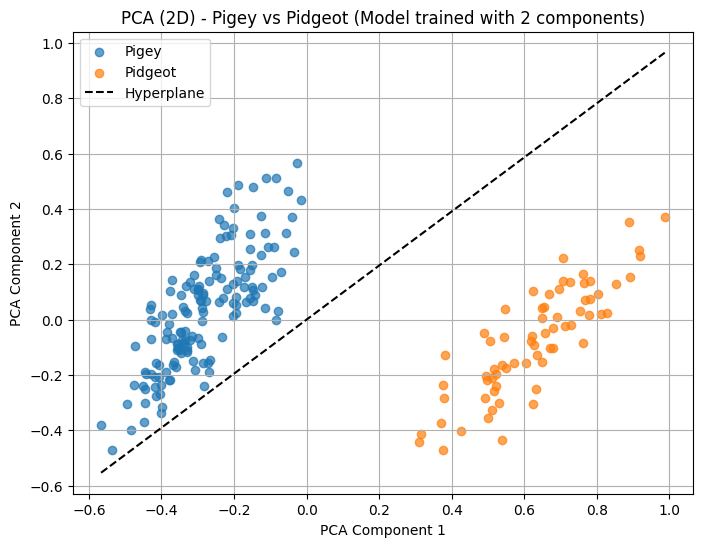

Accuracy (2 components): 1.0000, Error: 0.0000
Hyperplane equation: 0.2924*x1 + -0.2992*x2 + -0.0000 = 0


In [ ]:
# --- Visualization for PCA with 2 components ---
plt.figure(figsize=(8, 6))

plt.scatter(data_x_pca_2[data_y == 0, 0], data_x_pca_2[data_y == 0, 1], label="Pigey", alpha=0.7)
plt.scatter(data_x_pca_2[data_y == 1, 0], data_x_pca_2[data_y == 1, 1], label="Pidgeot", alpha=0.7)

plt.title("PCA (2D) - Pigey vs Pidgeot (Model trained with 2 components)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)

# Get PCA components and perceptron weights
V_2 = pca_2.components_
w_2 = perceptron_2.weights.numpy().flatten()
b_2 = perceptron_2.bias.numpy()[0]

# Decision boundary function in PCA space
def hyperplane_pca_2(pc1):
    return -(w_2[0] * pc1 + b_2) / w_2[1]

# Generate range for x values and compute corresponding y values
x_vals_2 = np.linspace(data_x_pca_2[:, 0].min(), data_x_pca_2[:, 0].max(), 100)
y_vals_2 = hyperplane_pca_2(x_vals_2)

# Plot the decision boundary
plt.plot(x_vals_2, y_vals_2, 'k--', label='Hyperplane')

plt.legend()
plt.show()

print(f"Accuracy (2 components): {accuracy_2:.4f}, Error: {error_2:.4f}")
print(f"Hyperplane equation: {w_2[0]:.4f}*x1 + {w_2[1]:.4f}*x2 + {b_2:.4f} = 0")


In [ ]:
# Get PCA components and perceptron weights for 3D
V_3 = pca_3.components_
w_3 = perceptron_3.weights.numpy().flatten()
b_3 = perceptron_3.bias.numpy()[0]

# Extract points for each class
class_0 = data_x_pca_3[data_y == 0]
class_1 = data_x_pca_3[data_y == 1]

# Create 3D scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=class_0[:, 0], y=class_0[:, 1], z=class_0[:, 2],
    mode='markers',
    marker=dict(size=4, color='blue', opacity=0.7),
    name='Pigey'
))

fig.add_trace(go.Scatter3d(
    x=class_1[:, 0], y=class_1[:, 1], z=class_1[:, 2],
    mode='markers',
    marker=dict(size=4, color='orange', opacity=0.7),
    name='Pidgeot'
))

# Create mesh grid for decision plane
xx, yy = np.meshgrid(
    np.linspace(data_x_pca_3[:, 0].min(), data_x_pca_3[:, 0].max(), 10),
    np.linspace(data_x_pca_3[:, 1].min(), data_x_pca_3[:, 1].max(), 10)
)


zz = -(w_3[0] * xx + w_3[1] * yy + b_3) / w_3[2]

# Add decision plane
fig.add_trace(go.Surface(
    x=xx, y=yy, z=zz,
    colorscale='Greys', opacity=0.5,
    showscale=False,
    name='Decision Plane'
))

# Update layout
fig.update_layout(
    title="PCA (3D) - Pigey vs Pidgeot (Model trained with 3 components)",
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3',
    ),
    legend=dict(x=0.01, y=0.99)
)

fig.show()

print(f"Accuracy (3 components): {accuracy_3:.4f}, Error: {error_3:.4f}")
print(f"Hyperplane equation: {w_3[0]:.4f}*x1 + {w_3[1]:.4f}*x2 + {w_3[2]:.4f}*x3 + {b_3:.4f} = 0")


Accuracy (3 components): 1.0000, Error: 0.0000
Hyperplane equation: 1.0367*x1 + 0.0348*x2 + 0.6522*x3 + -0.2000 = 0


# **Comb 9: pidgeotto vs pidgeot (4 Features)**

In [ ]:
data_x = df_comb1[feature_cols].values
data_y = df_comb1["species"].values

scaler = MinMaxScaler()
data_x = scaler.fit_transform(data_x)

# --- PCA with 2 components ---
pca_2 = PCA(n_components=2)
data_x_pca_2 = pca_2.fit_transform(data_x)

# Convert to tensors for 2 components
X_train_2 = tf.convert_to_tensor(data_x_pca_2, dtype=tf.float32)
y_train = tf.convert_to_tensor(data_y, dtype=tf.int32)
X_test_2 = tf.convert_to_tensor(data_x_pca_2, dtype=tf.float32)
y_test = tf.convert_to_tensor(data_y, dtype=tf.int32)

# Train and evaluate with 2 components
perceptron_2 = Perceptron(units=2, activation=Step())
perceptron_2.fit(X_train_2, y_train, epochs=100, learning_rate=0.1)

correct_predictions_2 = 0
for i in range(X_test_2.shape[0]):
    prediction = perceptron_2.predict(X_test_2[i])
    if prediction == tf.cast(y_test[i], tf.int32):
        correct_predictions_2 += 1

accuracy_2 = correct_predictions_2 / X_test_2.shape[0]
error_2 = 1 - accuracy_2
print(f" Accuracy (2 components): {accuracy_2:.4f} Error: {error_2:.4f}")


# --- PCA with 3 components ---
pca_3 = PCA(n_components=3)
data_x_pca_3 = pca_3.fit_transform(data_x)

# Convert to tensors for 3 components
X_train_3 = tf.convert_to_tensor(data_x_pca_3, dtype=tf.float32)
X_test_3 = tf.convert_to_tensor(data_x_pca_3, dtype=tf.float32)

# Train and evaluate with 3 components
perceptron_3 = Perceptron(units=3, activation=Step())
perceptron_3.fit(X_train_3, y_train, epochs=100, learning_rate=0.1)

correct_predictions_3 = 0
for i in range(X_test_3.shape[0]):
    prediction = perceptron_3.predict(X_test_3[i])
    if prediction == tf.cast(y_test[i], tf.int32):
        correct_predictions_3 += 1

accuracy_3 = correct_predictions_3 / X_test_3.shape[0]
error_3 = 1 - accuracy_3
print(f" Accuracy (3 components): {accuracy_3:.4f} Error: {error_3:.4f}")

Se han truncado las últimas 5000 líneas del flujo de salida.

Epoch: 89, Iteration: 130, Input: [-0.34301493 -0.07199338 -0.05871228], Initial Weights: [ 0.4257594   0.01503889 -0.59050983], y: 0, t: 0, Error: 0.0, Final Weights: [ 0.4257594   0.01503889 -0.59050983]

Epoch: 89, Iteration: 131, Input: [-0.19227393  0.14097492 -0.1161681 ], Initial Weights: [ 0.4257594   0.01503889 -0.59050983], y: 0, t: 0, Error: 0.0, Final Weights: [ 0.4257594   0.01503889 -0.59050983]

Epoch: 89, Iteration: 132, Input: [-0.32857555  0.02499969 -0.06277043], Initial Weights: [ 0.4257594   0.01503889 -0.59050983], y: 0, t: 0, Error: 0.0, Final Weights: [ 0.4257594   0.01503889 -0.59050983]

Epoch: 89, Iteration: 133, Input: [-0.17202207  0.11880416  0.18277438], Initial Weights: [ 0.4257594   0.01503889 -0.59050983], y: 0, t: 0, Error: 0.0, Final Weights: [ 0.4257594   0.01503889 -0.59050983]

Epoch: 89, Iteration: 134, Input: [-0.3541213  -0.10250908 -0.0058603 ], Initial Weights: [ 0.4257594   0.0150

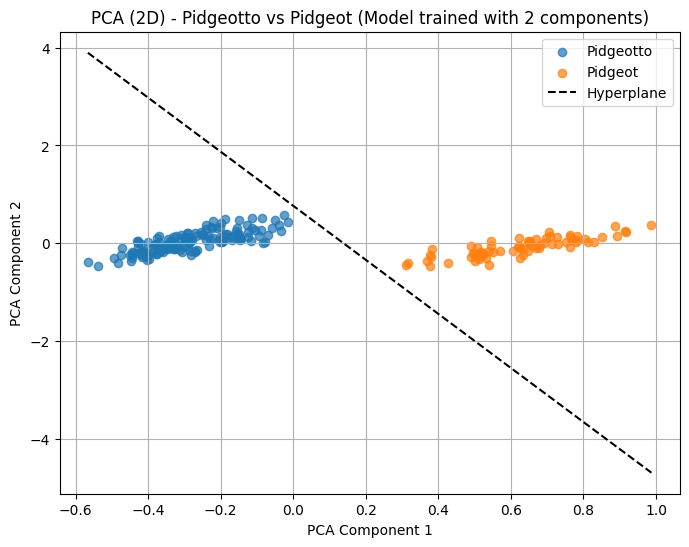

Accuracy (2 components): 1.0000, Error: 0.0000
Hyperplane equation: 0.7240*x1 + 0.1309*x2 + -0.1000 = 0


In [ ]:
# --- Visualization for PCA with 2 components ---
plt.figure(figsize=(8, 6))

# Scatter plot of data points
plt.scatter(data_x_pca_2[data_y == 0, 0], data_x_pca_2[data_y == 0, 1], label="Pidgeotto", alpha=0.7)
plt.scatter(data_x_pca_2[data_y == 1, 0], data_x_pca_2[data_y == 1, 1], label="Pidgeot", alpha=0.7)

plt.title("PCA (2D) - Pidgeotto vs Pidgeot (Model trained with 2 components)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)

# Get PCA components and perceptron weights
V_2 = pca_2.components_
w_2 = perceptron_2.weights.numpy().flatten()
b_2 = perceptron_2.bias.numpy()[0]

# Decision boundary function in PCA space
def hyperplane_pca_2(pc1):
    return -(w_2[0] * pc1 + b_2) / w_2[1]

# Generate range for x values and compute corresponding y values
x_vals_2 = np.linspace(data_x_pca_2[:, 0].min(), data_x_pca_2[:, 0].max(), 100)
y_vals_2 = hyperplane_pca_2(x_vals_2)


plt.plot(x_vals_2, y_vals_2, 'k--', label='Hyperplane')

plt.legend()
plt.show()

print(f"Accuracy (2 components): {accuracy_2:.4f}, Error: {error_2:.4f}")
print(f"Hyperplane equation: {w_2[0]:.4f}*x1 + {w_2[1]:.4f}*x2 + {b_2:.4f} = 0")


In [ ]:
# Get PCA components and perceptron weights for 3D
V_3 = pca_3.components_
w_3 = perceptron_3.weights.numpy().flatten()
b_3 = perceptron_3.bias.numpy()[0]

# Extract points for each class
class_0 = data_x_pca_3[data_y == 0]
class_1 = data_x_pca_3[data_y == 1]

# Create 3D scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=class_0[:, 0], y=class_0[:, 1], z=class_0[:, 2],
    mode='markers',
    marker=dict(size=4, color='blue', opacity=0.7),
    name='Pidgeotto'
))

fig.add_trace(go.Scatter3d(
    x=class_1[:, 0], y=class_1[:, 1], z=class_1[:, 2],
    mode='markers',
    marker=dict(size=4, color='orange', opacity=0.7),
    name='Pidgeot'
))

# Create mesh grid for decision plane
xx, yy = np.meshgrid(
    np.linspace(data_x_pca_3[:, 0].min(), data_x_pca_3[:, 0].max(), 10),
    np.linspace(data_x_pca_3[:, 1].min(), data_x_pca_3[:, 1].max(), 10)
)


zz = -(w_3[0] * xx + w_3[1] * yy + b_3) / w_3[2]

# Add decision plane
fig.add_trace(go.Surface(
    x=xx, y=yy, z=zz,
    colorscale='Greys', opacity=0.5,
    showscale=False,
    name='Decision Plane'
))

# Update layout
fig.update_layout(
    title="PCA (3D) - Pidgeotto vs Pidgeot (Model trained with 3 components)",
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3',
    ),
    legend=dict(x=0.01, y=0.99)
)

fig.show()

print(f"Accuracy (3 components): {accuracy_3:.4f}, Error: {error_3:.4f}")
print(f"Hyperplane equation: {w_3[0]:.4f}*x1 + {w_3[1]:.4f}*x2 + {w_3[2]:.4f}*x3 + {b_3:.4f} = 0")


Accuracy (3 components): 1.0000, Error: 0.0000
Hyperplane equation: 0.4258*x1 + 0.0150*x2 + -0.5905*x3 + -0.1000 = 0
